In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
data = pd.read_csv('eda_data.csv')

In [3]:
data.head()

,RelativeHumidity,Temperature_Celsius,Pressure_Millibar,MoonInfo_Phase,MoonInfo_Illumination,MoonInfo_Age,Precipitation_Hour_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,...,"CurrentConditions_Strong Thunderstorms, Rain",CurrentConditions_Thunderstorms,"CurrentConditions_Thunderstorms, Rain",SunInfo_IsSunUp,MoonInfo_IsMoonUp,Preassure_Millibar,day_sin,day_cos,year_sin,year_cos
0,0.509,13,1015.92,0.546387,0.978913,16.14,0.0,11.28,0.0,3.86,...,0,0,0,1,1,1015.92,-1.079200e-05,1.0,-0.003634,0.999993
1,0.368,27,1015.58,0.554403,0.971072,16.37,0.0,11.28,0.0,3.86,...,0,0,0,1,1,1015.58,-8.060721e-06,1.0,-0.008801,0.999961
2,0.303,28,1012.87,0.562377,0.962088,16.61,0.0,11.28,0.0,3.86,...,0,0,0,1,1,1012.87,-5.329445e-06,1.0,-0.013969,0.999902
3,0.468,23,1013.89,0.570309,0.951999,16.84,0.0,11.28,0.0,3.86,...,0,0,0,0,1,1013.89,-2.598168e-06,1.0,-0.003512,0.999994
4,0.530,21,1012.87,0.578202,0.940846,17.07,0.0,11.28,0.0,3.86,...,0,0,0,1,1,1012.87,1.331084e-07,1.0,-0.008679,0.999962


In [4]:
numeric_columns = ['RelativeHumidity', 'Temperature_Celsius', 'Pressure_Millibar',
       'MoonInfo_Phase', 'MoonInfo_Illumination',
       'MoonInfo_Age', 'Precipitation_Hour_Cm',
       'Precipitation_Year_Cm', 'Precipitation_Month_Cm',
       'Precipitation_Week_Cm', 'Precipitation_Day_Cm', 'Wind_X', 'Wind_Y',
       'Wind_Gust_KilometersPerHour']

Moving average normalization.  Done before the split since it should be rolling with all of the values throughout production as well.

In [5]:
moving_average = data[numeric_columns].rolling(window=3).mean()
normalized_moving_average_data = (moving_average - moving_average.min()) / (moving_average.max() - moving_average.min())
normalized_moving_average_data = normalized_moving_average_data.dropna()
normalized_moving_average_data.head()

,RelativeHumidity,Temperature_Celsius,Pressure_Millibar,MoonInfo_Phase,MoonInfo_Illumination,MoonInfo_Age,Precipitation_Hour_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Wind_X,Wind_Y,Wind_Gust_KilometersPerHour
2,0.136213,0.822222,0.455089,0.555482,0.971035,0.555530,0.0,0.287608,0.0,1.0,0.0,0.298550,0.484527,0.429806
3,0.116754,0.877778,0.442574,0.563587,0.962057,0.563561,0.0,0.287608,0.0,1.0,0.0,0.222448,0.450983,0.609611
4,0.193640,0.844444,0.425868,0.571650,0.951974,0.571592,0.0,0.287608,0.0,1.0,0.0,0.235697,0.504314,0.379590
5,0.225914,0.844444,0.432156,0.579672,0.940827,0.579624,0.0,0.287608,0.0,1.0,0.0,0.289026,0.430207,0.389849
6,0.295206,0.861111,0.417545,0.587656,0.928658,0.587655,0.0,0.287608,0.0,1.0,0.0,0.401238,0.469947,0.210043


In [6]:
length = len(normalized_moving_average_data)
train_ma_dataframe = normalized_moving_average_data[0:round(length*.7)]
valid_ma_dataframe = normalized_moving_average_data[round(length*.7):round(length*.9)]
test_ma_dataframe = normalized_moving_average_data[round(length*.9):]

In [7]:
from window_generator import WindowGenerator

In [8]:
window_moving_average = WindowGenerator(input_width=4*7, # use a week
                                        label_width=4*7, # predict a week
                                        shift=1, # predict the next day
                                        train_df=train_ma_dataframe,
                                        val_df=valid_ma_dataframe,
                                        test_df=test_ma_dataframe,
                                        label_columns=['Temperature_Celsius'])

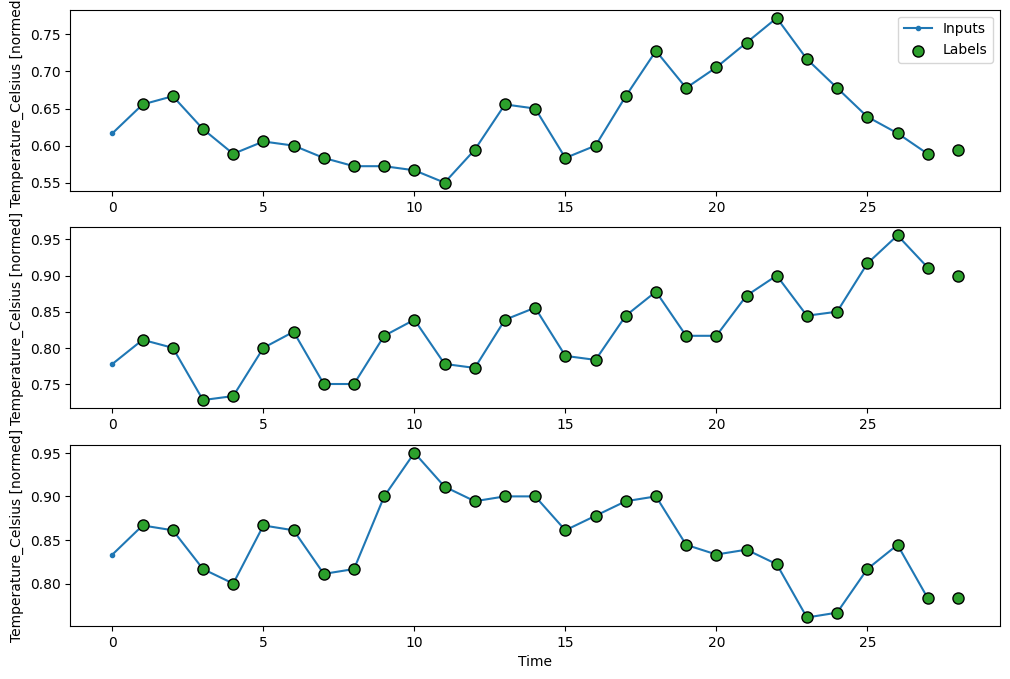

In [9]:
window_moving_average.plot()

In [10]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [11]:
dense_relu = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [12]:
dense_relu_large = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [13]:
models = {'linear':linear, 'dense_relu':dense_relu, 'dense_relu_large':dense_relu_large}

In [14]:
def compile_and_train(model, window, key, patience=2, epochs=20):
    print(key)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    return model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stop])

In [15]:
def train_models_by_window(models, window):
    return [compile_and_train(model, window, key) for key, model in models.items()]

In [16]:
val_performance = {}
performance = {}
history_of_models = train_models_by_window(models, window_moving_average)

val_performance['linear'] = linear.evaluate(window_moving_average.val)
performance['linear'] = linear.evaluate(window_moving_average.test)

val_performance['dense_relu'] = dense_relu.evaluate(window_moving_average.val)
performance['dense_relu'] = dense_relu.evaluate(window_moving_average.test)

val_performance['dense_relu_large'] = dense_relu_large.evaluate(window_moving_average.val)
performance['dense_relu_large'] = dense_relu_large.evaluate(window_moving_average.test)

linear
Epoch 1/20
160/160 [==============================] - 1s 3ms/step - loss: 0.0509 - mean_absolute_error: 0.1797 - val_loss: 0.0897 - val_mean_absolute_error: 0.2423
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0237 - mean_absolute_error: 0.1245 - val_loss: 0.0620 - val_mean_absolute_error: 0.2031
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0159 - mean_absolute_error: 0.1035 - val_loss: 0.0402 - val_mean_absolute_error: 0.1641
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0111 - mean_absolute_error: 0.0872 - val_loss: 0.0243 - val_mean_absolute_error: 0.1273
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0744 - val_loss: 0.0138 - val_mean_absolute_error: 0.0952
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0642 - val_loss: 0.0081 - val_mean_absolute_error: 0.0724
Epoch 7/2

In [17]:
import numpy as np
import matplotlib.pyplot as plt

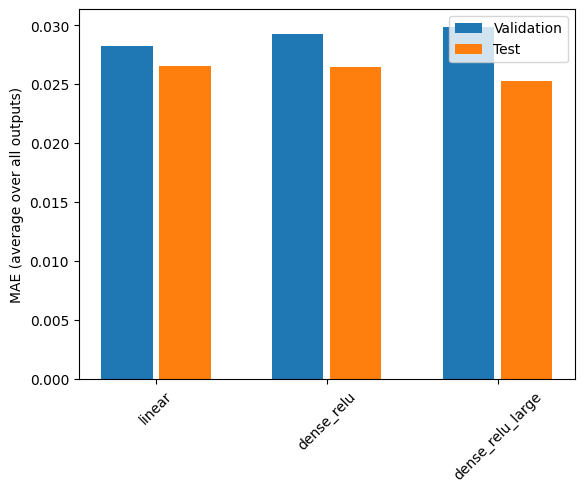

In [18]:
# @Author : Google TF
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = linear.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()